---
# Finetuning CNN using regression loss

- CNN are proven to be a better model of visual cortex, but the goal of visual cortex is not limited to image classification.

- Typically, to model visual cortex responses using CNNs, we -

  1. Extract features of intermediate layers
  2. Reduce dimensionality of the data using techniques like PCA
  3. Perform regression to predict neural data.

- This approach fails to predict all the variance in the data.

**A better approach is to train CNNs directly on the neural response.**

---
# Setup

In [ ]:
# @title Install dependencies
!pip install Pillow --quiet
!pip install git+https://github.com/dicarlolab/CORnet.git
!pip install torch_intermediate_layer_getter --quiet

  Cloning https://github.com/dicarlolab/CORnet.git to /tmp/pip-req-build-zhob3y60
  Running command git clone --filter=blob:none --quiet https://github.com/dicarlolab/CORnet.git /tmp/pip-req-build-zhob3y60
  Resolved https://github.com/dicarlolab/CORnet.git to commit d0cc17d4b34ad44dedb01683b70eafd15515adad
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using ca

In [ ]:
#  Imports
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn, optim
from cornet import cornet_s
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

import copy

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

from torchvision import transforms
import torchvision.models as models


from scipy.spatial.distance import pdist
from scipy.stats import pearsonr


In [ ]:
# @title Downloading Kay dataset
import requests

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]

urls =['https://osf.io/r638s/download',
       'https://osf.io/yqb3e/download',
       'https://osf.io/ymnjv/download']

for i, url in enumerate(urls):
  r = requests.get(url, allow_redirects=True)
  with open(fnames[i], 'wb') as fh:
    fh.write(r.content)


with np.load(fnames[2]) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

In [ ]:
dat["stimuli"].shape

(1750, 128, 128)

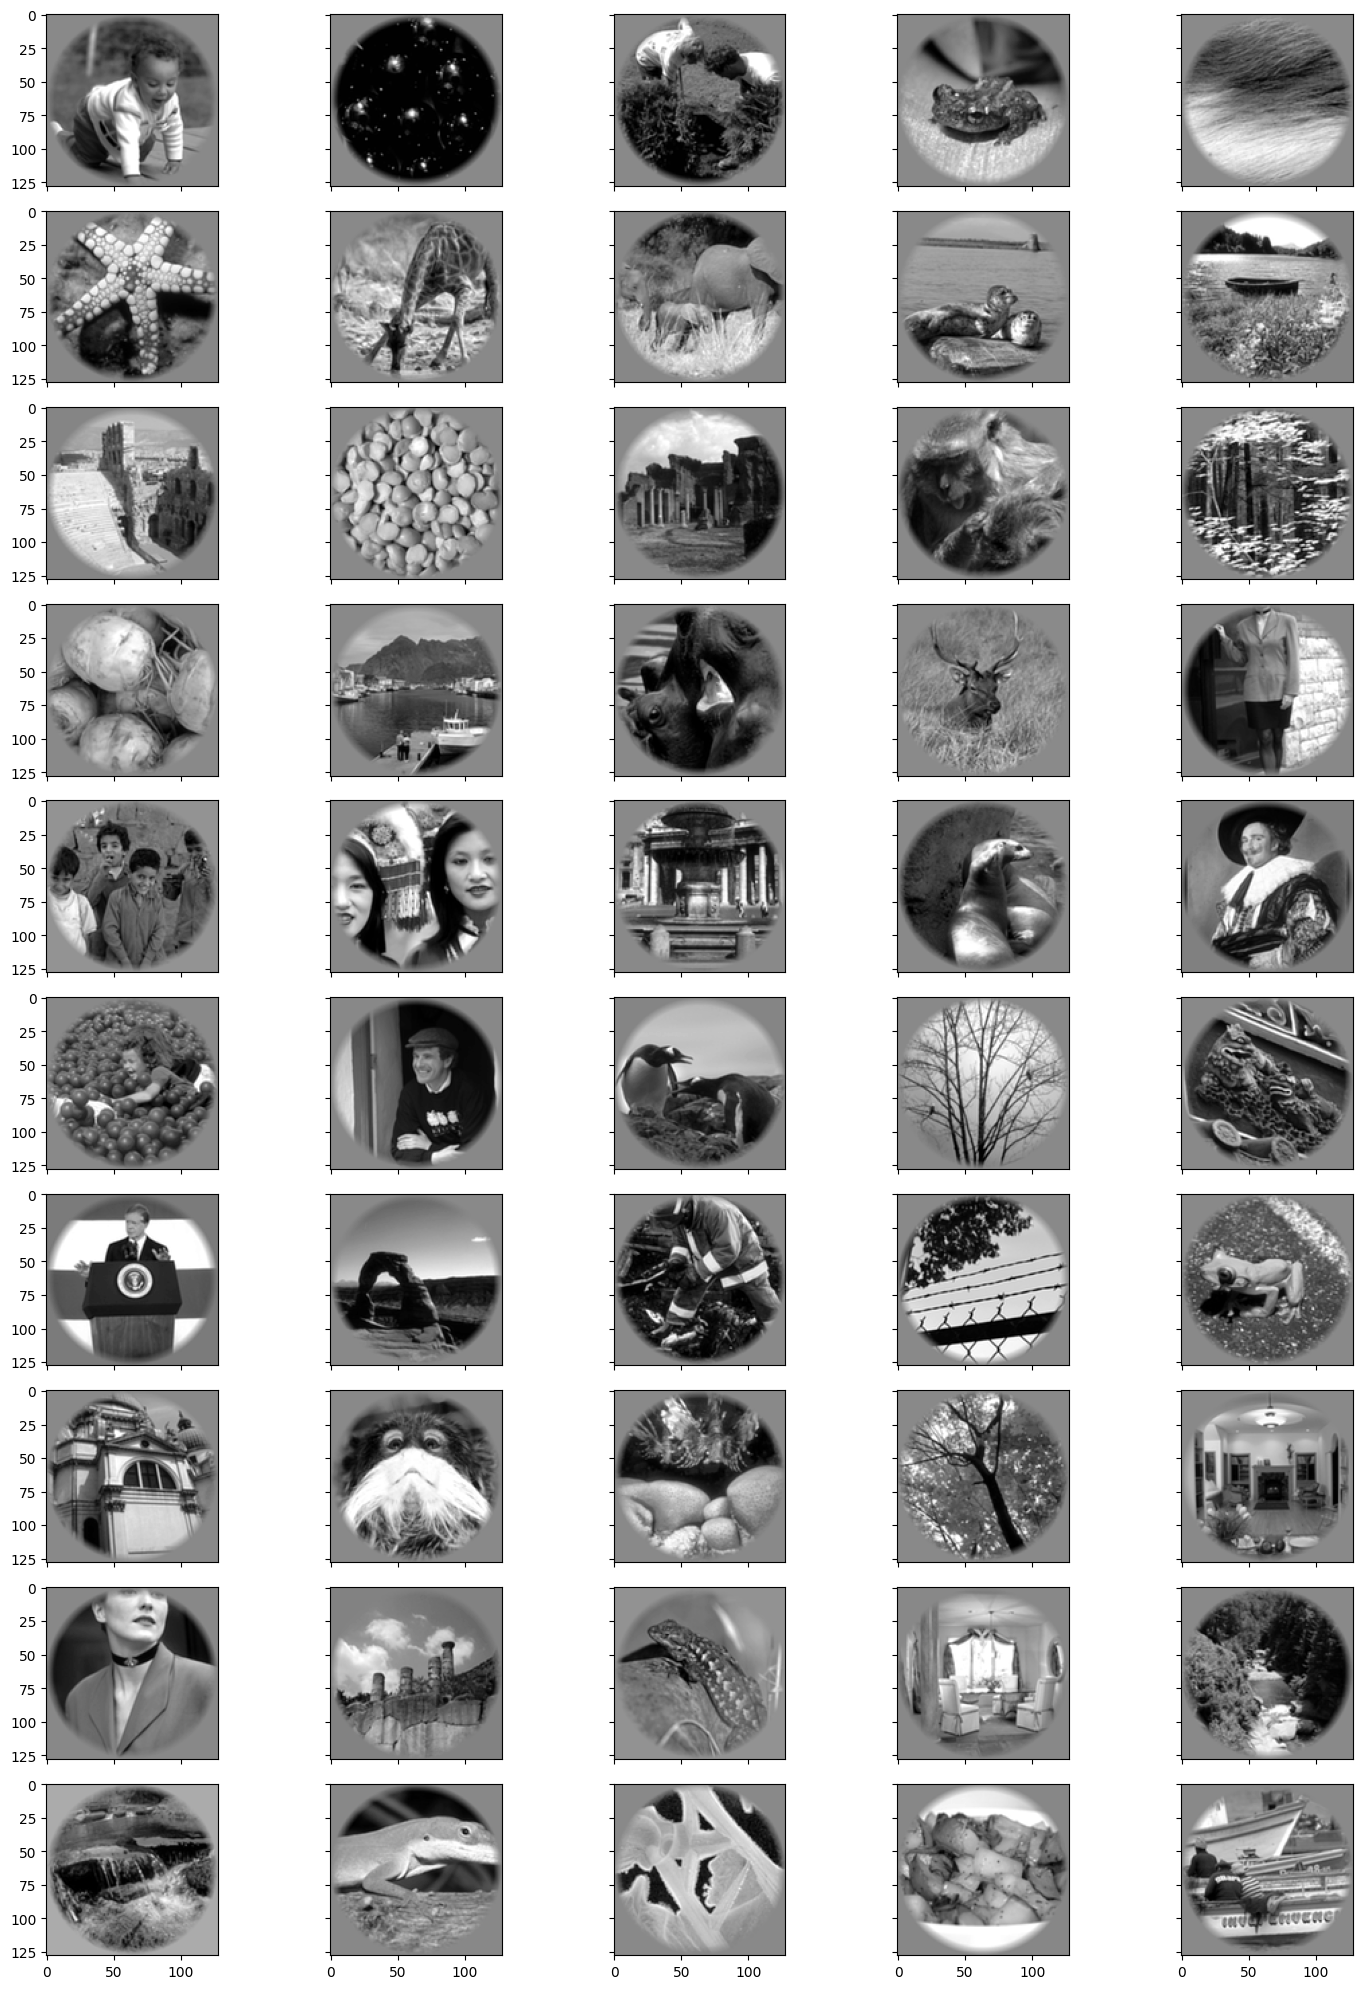

In [ ]:
# @title Visualizing example images
f, axs = plt.subplots(10, 5, figsize=(15, 20), sharex=True, sharey=True)
for ax, im in zip(axs.flat, dat["stimuli"]):
  ax.imshow(im, cmap="gray")
f.tight_layout()
plt.show()

---
# Dataset Structure

`dat` has the following fields:  
- `stimuli`: stim $x_i \, \, x_j$ array of grayscale stimulus images
- `stimuli_test`: stim $x_i \, \, x_j$ array of grayscale stimulus images in the test set  
- `responses`: stim $x$ voxel array of $z$-scored BOLD response amplitude
- `responses_test`:  stim $x$ voxel array of $z$-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [ ]:
# Converting stimulus to RGB and changing the scale to 0-255 (Specific to Kay dataset images)
stimuli_tr = dat["stimuli"]
stimuli_ts = dat["stimuli_test"]
stimuli_tr_xformed = np.zeros((1750, 3, 128, 128))
stimuli_ts_xformed = np.zeros((120, 3, 128, 128))
for i in range(1750):
  img = stimuli_tr[i, :, :]
  img = ((img - np.min(img))*255/(np.max(img) - np.min(img))).astype(int)
  stimuli_tr_xformed[i, :, :, :] = [img,img,img]

for i in range(120):
  img = stimuli_ts[i, :, :]
  img = ((img - np.min(img))*255/(np.max(img) - np.min(img))).astype(int)
  stimuli_ts_xformed[i, :, :, :] = [img, img, img]

---
# Fine Tuning AlexNet on voxel activations





In [ ]:
# @title Setting up training and test data for LOC region
loc_id = np.where(dat['roi'] == 7)
response_tr = np.squeeze(dat["responses"][:, loc_id])
response_ts = np.squeeze(dat["responses_test"][:, loc_id])

In [ ]:
# @title Custom dataloader for loading images in numpy array
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
    self.data = data
    self.targets = torch.LongTensor(targets)
    self.transform = transform

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]

    if self.transform:
        x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
        x = self.transform(x)

    return x, y

  def __len__(self):
      return len(self.data)


transform = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                #  transforms.RandomHorizontalFlip(),
                                #  transforms.RandomVerticalFlip(p=0.5),  # new (vertical transform)
                                #  transforms.RandomRotation(60),          # new (rotation)
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])
                                 ]),
    'val': transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                              # transforms.RandomHorizontalFlip(),       # new (vertical transform)
                              #  transforms.RandomRotation(60),            # new (rotation)
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])
                               ]),
             }

dataset = {}
dataset['train'] = MyDataset(list(stimuli_tr_xformed),
                             list(response_tr), transform=transform['train'])
dataset['val'] = MyDataset(list(stimuli_ts_xformed),
                           list(response_ts), transform=transform['val'])
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=50) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<ipython-input-8-6f212c45c5c8>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  self.targets = torch.LongTensor(targets)


In [ ]:
from cornet import cornet_s

In [ ]:
# Training
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = cornet_s(pretrained=True)
num_ftrs = net.module[4][2].in_features
net.module[4][2] = nn.Linear(num_ftrs, np.shape(response_ts)[1])

net.to(device)
criterion = nn.MSELoss()
learning_rate = 0.1  # Change this
num_epochs =  3 # Change this
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)



best_model_wts = copy.deepcopy(net.state_dict())
best_loss = 10.0

for epoch in range(num_epochs):
	print(f"Epoch {epoch}/{num_epochs - 1}")
	print('-' * 20)

	# Each epoch has a training and validation phase
	for phase in ['train', 'val']:
		if phase == 'train':
			net.train()  # Set model to training mode
		else:
			net.eval()   # Set model to evaluate mode

		running_loss = 0.0
		running_corrects = 0

		# Iterate over data.
		for inputs, labels in dataloaders[phase]:
			inputs = inputs.to(device)
			labels = labels.to(device)

			# zero the parameter gradients
			optimizer.zero_grad()

			# forward
			# track history if only in train
			with torch.set_grad_enabled(phase == 'train'):
				outputs = net(inputs)
				loss = criterion(outputs.float(), labels.float())

				# backward + optimize only if in training phase
				if phase == 'train':
					loss.backward()
					optimizer.step()

			# statistics
			running_loss += loss.item() * inputs.size(0)

		epoch_loss = running_loss / dataset_sizes[phase]
		print(f"{phase} Loss: {epoch_loss:.4f}")

		# deep copy the model
		if phase == 'val' and epoch_loss < best_loss:
			best_loss = epoch_loss
			best_model_wts = copy.deepcopy(net.state_dict())

	print()

# load best model weights
net.load_state_dict(best_model_wts)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
# from torchvision import transforms as T
# from torchvision import transforms as trn
# import torchextractor as tx

# def my_preprocessor(image, model_name, device):
#     """
#     Args:
#         image (Union[Image.Image, List[Image.Image]]): A PIL Image or a list of PIL Images.
#         model_name (str): The name of the model, used to determine specific preprocessing if necessary.
#         device (str): The device to which the tensor should be transferred ('cuda' for GPU, 'cpu' for CPU).

#     Returns:
#         Union[torch.Tensor, List[torch.Tensor]]: The preprocessed image(s) as PyTorch tensor(s).
#     """

#     transforms = trn.Compose([
#         trn.Resize((224, 224)),
#         trn.ToTensor(),
#         trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])

#     img_tensor = transforms(image).unsqueeze(0)
#     if device == 'cuda':
#         img_tensor = img_tensor.cuda()

#     return img_tensor


# def my_extactor(preprocessed_data, layers_to_extract, model):
#     # Create a extractor instance
#     extractor_model = tx.Extractor(model, layers_to_extract)

#     # Extract actual features
#     _, features = extractor_model(preprocessed_data)

#     return features


# def my_cleaner(features):
#     return features


# Define a model
# model = net  # This one exists in the toolbox as well, it is just supposed to be an example!

# ## Define extractor (Note: NO NETSET NEEDED HERE)
# fx = FeatureExtractor(model=model, netset_fallback="Standard", device='cpu' )  #,  preprocessor=my_preprocessor, feature_cleaner=my_cleaner, extraction_function=my_extactor)

# # Run extractor
# fx.extract(stimuli_path, layers_to_extract=['V1', 'V2', 'V4', 'IT'])

In [ ]:
class MidGetter(nn.Module):
    def __init__(self, model, return_layers, keep_output=False):
        super(MidGetter, self).__init__()
        self.model = model.module if isinstance(model, torch.nn.DataParallel) else model
        self.return_layers = return_layers
        self.keep_output = keep_output
        self._register_hooks()

    def _register_hooks(self):
        self.outputs = {}

        def hook(module, input, output, layer_name):
            self.outputs[layer_name] = output

        for name, layer in self.model.named_modules():
            if name in self.return_layers.values():
                layer.register_forward_hook(lambda m, i, o, n=name: hook(m, i, o, n))

    def forward(self, x):
        self.outputs = {}
        out = self.model(x)
        if self.keep_output:
            self.outputs['output'] = out
        return {key: self.outputs[layer] for key, layer in self.return_layers.items()}, out


In [ ]:
## Extract features of all the intermediate layers from ImageNet-trained and finetuned Alexnet
# return_layers = {
#     'features.2': 'conv1',
#     'features.5': 'conv2',
#     'features.7': 'conv3',
#     'features.9': 'conv4',
#     'features.12': 'conv5',
#     'classifier.1': 'fc1',
#     'classifier.4': 'fc2',
#     'classifier.6': 'fc3',
#     }

return_layers = {
    'V1_output': 'V1',
    'V2_output': 'V2',
    'V4_output': 'V4',
    'IT_output': 'IT',
    'decoder': 'decoder'
}

# Loading AlexNet pretrained on Imagenet
# net_im = models.alexnet(pretrained=True)
net = cornet_s(pretrained=True)
net = torch.nn.DataParallel(net)
net.eval()
net.to(device)


# Setting up feature extraction step
midfeat_ft = MidGetter(net.module, return_layers=return_layers, keep_output=True)
midfeat_im = MidGetter(net.module, return_layers=return_layers, keep_output=True)

# Loading validation data and forward pass through the network
dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=60) for x in ['val']}
for inputs, labels in dataloaders['val']:
  inputs = inputs.to(device)
  mid_outputs_ft, _ = midfeat_ft(inputs)
  mid_outputs_im, _ = midfeat_im(inputs)

## all the 'roi's

editted


updated code

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

# Assuming the following are defined
# dat: dictionary containing your fMRI data
# dataset: dictionary containing your dataset
# device: your computation device (e.g., 'cpu' or 'cuda')
# midfeat_ft, midfeat_im: functions or models that produce the intermediate features
# return_layers: list of layers in the network

# Define roi_ids and layers for this example
roi_ids = [1, 2, 3, 4, 5, 6, 7]  # Example ROI ids
layers = return_layers  # Example layers
mid_outputs_ft = {layer: idx for idx, layer in enumerate(layers)}

plt.figure(figsize=(16, 10))

roi_names = ["ROI " + str(roi_id) for roi_id in roi_ids]
r_all_roi = {}

# Calculate r and p for each ROI
for roi_id in roi_ids:
    roi_indices = np.where(dat['roi'] == roi_id)[0]

    # Select the first 60 samples from fMRI responses to match the network outputs
    fMRI_responses = np.squeeze(dat["responses_test"][:60, roi_indices])

    # Initialize observed dissimilarities
    dobs = {}
    for metric in ['correlation', 'euclidean']:
        dobs[metric] = pdist(fMRI_responses, metric)

    # Initialize dataloaders
    dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=60) for x in ['val']}

    # Forward pass through the network and extract features
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        mid_outputs_ft, _ = midfeat_ft(inputs)
        mid_outputs_im, _ = midfeat_im(inputs)
        break  # Assume we're only using one batch for demonstration purposes

    # Comparing representation of each ROI across different layers of the network
    layers = list(mid_outputs_ft.keys())
    r, p = np.zeros((4, len(layers))), np.zeros((4, len(layers)))

    for i, l in enumerate(layers):
        # Flatten and convert to numpy arrays
        flattened_ft = torch.flatten(mid_outputs_ft[l], 1, -1).cpu().detach().numpy()
        flattened_im = torch.flatten(mid_outputs_im[l], 1, -1).cpu().detach().numpy()

        # Calculate pairwise distances
        dnet_ft = pdist(flattened_ft, 'euclidean')
        dnet_im = pdist(flattened_im, 'correlation')

        for j, metric in enumerate(dobs.keys()):
            if len(dnet_ft) == len(dobs[metric]):
                r[j, i], p[j, i] = pearsonr(dnet_ft, dobs[metric])
            else:
                print(f"Skipping layer {l} for ROI {roi_id} due to length mismatch for metric {metric}.")

    r_all_roi[f"ROI {roi_id}"] = (r, p)
    print(f"Correlation coefficients for ROI {roi_id}:", r)
    print(f"P-values for ROI {roi_id}:", p)

# Plot the results for each ROI
for roi_name in roi_names:
    r, p = r_all_roi[roi_name]

    plt.figure()
    for i in range(4):  # Assuming you have 4 metrics
        plt.bar(range(len(layers)), r[i, :], alpha=0.5)

    plt.legend(['Fine tuned', 'Image Net'])
    plt.ylabel('Correlation coefficient')
    plt.title(f'Match to {roi_name}')
    plt.xticks(range(len(layers)), mid_outputs_ft.keys())
    plt.show()


In [ ]:
def plot_corr_matrix(rdm, ax=None, show=False):
  """Plot dissimilarity matrix

  Args:
    rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity
      matrix
    ax (matplotlib axes): axes onto which to plot

  Returns:
    nothing

  """
  if ax is None:
    ax = plt.gca()
  image = ax.imshow(rdm, vmin=0.0, vmax=2.0)
  ax.set_xticks([])
  ax.set_yticks([])
  cbar = plt.colorbar(image, ax=ax, label='dissimilarity')
  if show:
    plt.show()

def plot_multiple_rdm(rdm_dict):
  """Draw multiple subplots for each RDM in rdm_dict."""
  fig, axs = plt.subplots(1, len(rdm_dict),
                          figsize=(4 * len(resp_dict), 3.5))

  # Compute RDM's for each set of responses and plot
  for i, (label, rdm) in enumerate(rdm_dict.items()):

    image = plot_corr_matrix(rdm, axs)
    axs.set_title(label)
  plt.show()

In [ ]:
# @title all in one!
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

def RDM(resp):
    """Compute the representational dissimilarity matrix (RDM)

    Args:
        resp (ndarray): S x N matrix with population responses to
                        each stimulus in each row

    Returns:
        ndarray: S x S representational dissimilarity matrix
    """
    # z-score responses to each stimulus
    zresp = zscore(resp, axis=1)

    # Compute RDM
    RDM = 1 - (zresp @ zresp.T) / zresp.shape[1]

    return RDM

# Get unique ROIs
unique_rois = np.unique(dat['roi'])

# Prepare a figure for subplots
fig, axes = plt.subplots(len(unique_rois), 1, figsize=(10, 8 * len(unique_rois)))

for i, roi_id in enumerate(unique_rois):
    # Get responses for the current ROI
    roi_indices = np.where(dat['roi'] == roi_id)[0]
    Rts_roi = np.squeeze(dat["responses_test"][:, roi_indices])

    # Compute RDM for the current ROI
    rdm_matrix = RDM(Rts_roi)

    # Plot the RDM
    sns.heatmap(rdm_matrix, ax=axes[i], cmap='viridis', annot=False)
    axes[i].set_title(f'Representational Dissimilarity Matrix (RDM) for ROI: {dat["roi_names"][roi_id]}')
    axes[i].set_xlabel('Stimulus')
    axes[i].set_ylabel('Stimulus')

plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import os

# Create a directory to save the RDMs
rdm_folder = 'rdm_matrices'
os.makedirs(rdm_folder, exist_ok=True)

# Loop through unique ROIs and save their RDMs in .npz format
for roi_id in unique_rois:
    # Get responses for the current ROI
    roi_indices = np.where(dat['roi'] == roi_id)[0]
    Rts_roi = np.squeeze(dat["responses_test"][:, roi_indices])

    # Compute RDM for the current ROI
    rdm_matrix = RDM(Rts_roi)

    # Save the RDM matrix as a .npz file
    filename = os.path.join(rdm_folder, f'rdm_roi_{roi_id}.npz')
    np.savez(filename, rdm=rdm_matrix)

print(f"RDMs saved in '{rdm_folder}' directory.")

In [ ]:
! pip install -U git+https://github.com/cvai-roig-lab/Net2Brain

In [ ]:
from net2brain.taxonomy import show_all_architectures
from net2brain.taxonomy import show_all_netsets
from net2brain.taxonomy import show_taxonomy
from net2brain.taxonomy import print_netset_models

from net2brain.taxonomy import find_model_like_name
from net2brain.taxonomy import find_model_by_dataset
from net2brain.taxonomy import find_model_by_training_method
from net2brain.taxonomy import find_model_by_visual_task
from net2brain.taxonomy import find_model_by_custom
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path


In [ ]:
import numpy as np

# Load the npz file
data = np.load('kay_images.npz')  # Adjust the filename if necessary

# Check the keys in the npz file
print(data.files)

In [ ]:
import numpy as np
import os
from PIL import Image

# Load your dataset
dat = np.load('kay_images.npz')  # Replace with the actual file name or adjust as necessary

# Extract training and testing stimuli
stimuli_tr = dat["stimuli"]
stimuli_ts = dat["stimuli_test"]

# Output directories
output_dir_tr = 'kay_images_jpg/training'
output_dir_ts = 'kay_images_jpg/testing'
os.makedirs(output_dir_tr, exist_ok=True)
os.makedirs(output_dir_ts, exist_ok=True)

# Transforming training stimuli and saving as JPEG
stimuli_tr_xformed = np.zeros((1750, 3, 128, 128), dtype=np.uint8)
for i in range(1750):
    img = stimuli_tr[i, :, :]
    img = ((img - np.min(img)) * 255 / (np.max(img) - np.min(img))).astype(np.uint8)
    stimuli_tr_xformed[i, :, :, :] = np.stack((img, img, img), axis=0)  # Create an RGB image from the grayscale

    # Convert to PIL Image and save
    img_pil = Image.fromarray(stimuli_tr_xformed[i].transpose(1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    img_name = os.path.join(output_dir_tr, f'img_tr_{i:04d}.jpg')
    img_pil.save(img_name)

print(f"Saved {len(stimuli_tr)} training images to {output_dir_tr}.")

# Transforming testing stimuli and saving as JPEG
stimuli_ts_xformed = np.zeros((120, 3, 128, 128), dtype=np.uint8)
for i in range(120):
    img = stimuli_ts[i, :, :]
    img = ((img - np.min(img)) * 255 / (np.max(img) - np.min(img))).astype(np.uint8)
    stimuli_ts_xformed[i, :, :, :] = np.stack((img, img, img), axis=0)  # Create an RGB image from the grayscale

    # Convert to PIL Image and save
    img_pil = Image.fromarray(stimuli_ts_xformed[i].transpose(1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    img_name = os.path.join(output_dir_ts, f'img_ts_{i:04d}.jpg')
    img_pil.save(img_name)

print(f"Saved {len(stimuli_ts)} testing images to {output_dir_ts}.")

In [ ]:
stimuli_path = '/content/kay_images_jpg/testing'

In [ ]:
from net2brain.feature_extraction import FeatureExtractor
# fx = FeatureExtractor(model='cornet_s', netset='Cornet', device='cpu')
# fx.extract(data_path=stimuli_path, save_path='cornet_Feat',   consolidate_per_layer=False)

# Define a model
model = net  # This one exists in the toolbox as well, it is just supposed to be an example!


# Define extractor (Note: Define `netset_fallback` instead of `netset`)
fx = FeatureExtractor(model=model, netset_fallback="Standard", device='cpu')

# Run extractor
fx.extract(data_path=stimuli_path,  save_path='cornet_Feat', layers_to_extract=['V1', 'V2', 'V4', 'IT'])

In [ ]:
fx.layers_to_extract

In [ ]:
from net2brain.rdm_creation import RDMCreator

feat_path = "cornet_Feat"     # cornet features
save_path = "cornet_RDM"


# Call the Class with the path to the features
creator = RDMCreator(verbose=True, device='cpu')
save_path = creator.create_rdms(feature_path=feat_path, save_path=save_path, save_format='npz')

In [ ]:
creator.distance_functions()

In [ ]:
# from net2brain.rdm_creation import LayerRDM

# rdm = LayerRDM.from_file("cornet_RDM/RDM_consolidated_V1.npz")
# print(rdm)
# rdm.plot()

In [ ]:
from net2brain.evaluations.rsa import RSA_fmri
from net2brain.evaluations.rsa import RSA
from net2brain.utils.download_datasets import DatasetBonnerPNAS2017
from pprint import pprint

In [ ]:
# stimuli_path = paths_bonner["stimuli_path"]
# roi_path = '/content/rdm_matrices'

model_rdms = "cornet_RDM"
brain_rdms = '/content/rdm_matrices'

# Start RSA
evaluation_alexnet = RSA(model_rdms, brain_rdms, model_name="cornet_s")

# Evaluation - Returns a pandas dataframe
dataframe1 = evaluation_alexnet.evaluate()

# Show results
display(dataframe1)

In [ ]:
from net2brain.evaluations.plotting import Plotting

plotter = Plotting([dataframe1])
results_dataframe = plotter.plot()

In [ ]:
results_dataframe = plotter.plot(metric="R")

In [ ]:
results_dataframe = plotter.plot_all_layers(metric="R2")